# Problem set #3
### by Alexander Tyan, January 24, 2018

## 1).

In [403]:
# Import packages and load the data
import numpy as np
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
cmap1 = matplotlib.cm.get_cmap('summer')
# This next command is specifically for Jupyter Notebook
%matplotlib notebook

incomes_data = np.loadtxt('incomes.txt')

### a). Plot a histogram of percentages of the income.txt data with 30 bins. Make sure that the bins are weighted using the normed=True option. Make sure your plot has correct x-axis and y-axis labels as well as a plot title.

<IPython.core.display.Javascript object>


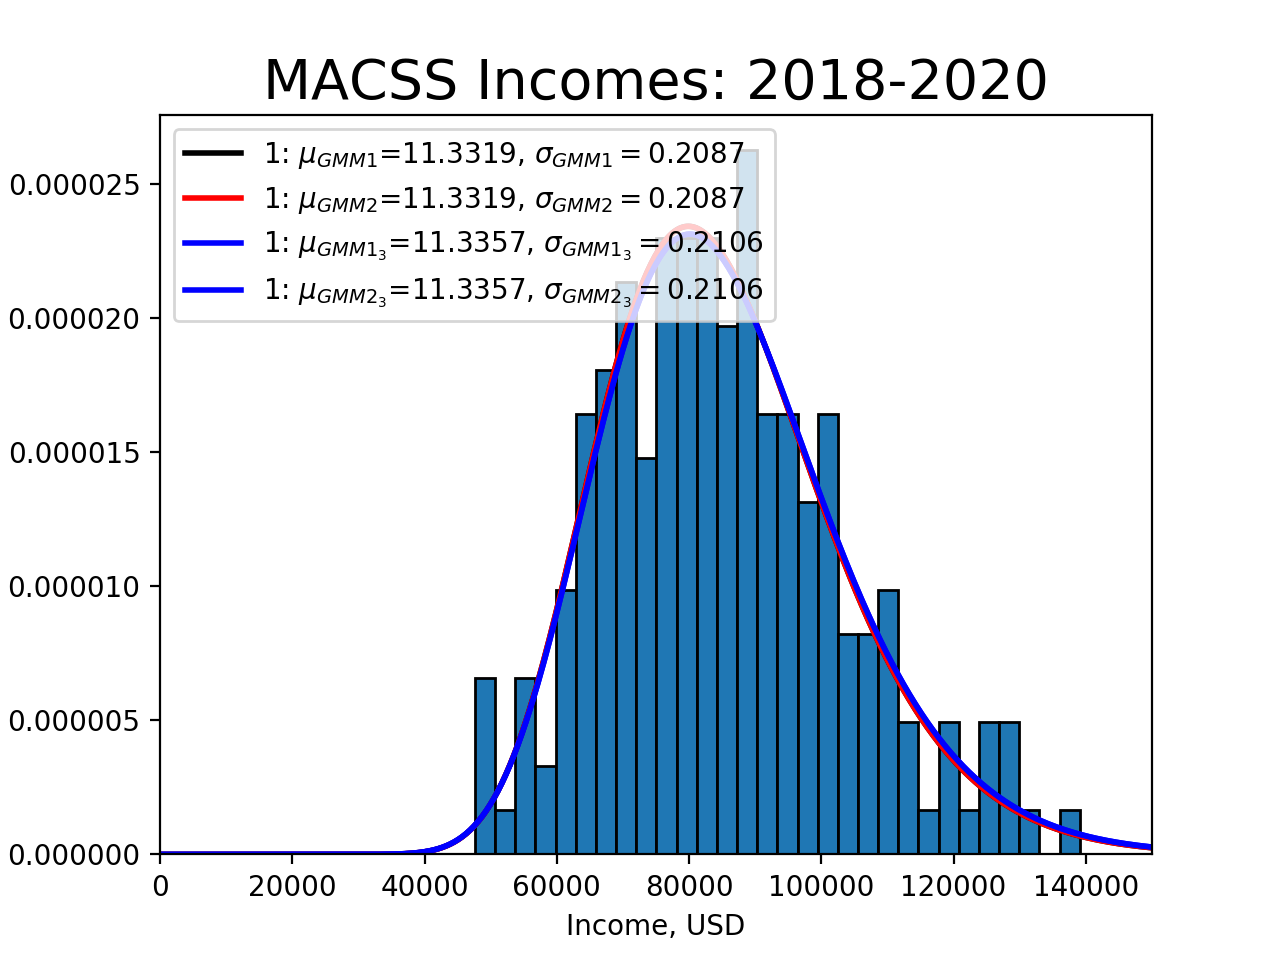

(0, 150000)

In [404]:
count, bins, ignored = plt.hist(incomes_data, bins=30, edgecolor='black', normed=True)
plt.title('MACSS Incomes: 2018-2020', fontsize=20)
plt.xlabel('Income, USD')
plt.ylabel('Proportion of Income') # Not sure why y-axis label is not showing up (?)
plt.xlim([0, 150000]) 

### b). Estimate the parameters of the lognormal distribution by generalized method of moments. 

In [405]:
# Define function that generates values of a lognormal pdf:
def lognormal_pdf(xvals, mu, sigma):
    """
    Generates a vector of values from a lognormal distribution.
    Inputs:
        xvals: Numpy array, vector of x-values
        mu: Integer mean
        sigma: Integer standard deviation
    Returns:
        pdf_vals: Numpy array, vector of y-values, i.e. pdf-values.
    """
    pdf_vals = ( 1 / 
           (xvals * sigma * np.sqrt(2 * np.pi))) * np.exp( (- (np.log(xvals) - mu) ** 2) / (2 * (sigma ** 2)))
    return pdf_vals

Function to calculate $m(x)$ - Rx1 vector of moments from real data:

In [406]:
def data_moments(xvals):
    """
    Takes in continuous data and returns mean and standard deviation.
    Inputs:
        xvals: Numpy array of data
    Return:
        
    """
    data_mean = xvals.mean()
    data_sd = xvals.std()
    
    return data_mean, data_sd

Function to calculate $m(x|\theta)$ - Rx1 vector of moments from the model:

In [407]:
def model_moments(mu, sigma):
    """
    Takes mean and SD values, and calculates mean and SD from using a
    PDF intergral.
    Inputs:
        mu: float, mean
        sigma: float, standard deviation
    Returns:
        mean_model: float, model's mean
        
    """
    # This freaks Python out, b/c of infities I think:
    #xfx = lambda x: x * lognormal_pdf(x, mu, sigma)
    #(model_mean, m_m_err) = intgr.quad(xfx, -np.inf, +np.inf)
    
    # This doesn't (Saw formula for lognormal mean on wikipedia):
    model_mean = np.exp(mu + ((sigma ** 2) / 2))
    
    #x2fx = lambda x: ((x - model_mean) ** 2) * lognormal_pdf(x, mu, sigma)
    #(model_var, v_m_err) = intgr.quad(x2fx, 0, +np.inf)
    
    # Likewise, let's try formula for SD, instead of intergral:
    model_var = (np.exp(sigma ** 2) - 1) * (np.exp(2 * mu + sigma ** 2))
    model_sd = np.sqrt(model_var)
    
    return model_mean, model_sd

Function to calculate $e(x|\theta)$ - Rx1 vector of percent difference:
$e(x|\theta) = \frac{m(x|\theta) - m(x)}{m(x)}$:

In [408]:
def err_vec(xvals, mu, sigma):
    """
    Takes observation values, mean and sd and calculates the values of
    the moment error function (e(x|theta))
    Inputs:
        xvals: Numpy array of observations
        mu: float, mean
        sigma: float, sd
    Returns:
        err_vec: Numpy array of he values of the moment error function
        as the percent difference
    """
    # m(x|theta):
    model_mean, model_sd = model_moments(mu, sigma)
    moments_from_model = np.array([[model_mean], [model_sd]])
    
    # m(x):
    data_mean, data_sd = data_moments(xvals)
    moments_from_data = np.array([[data_mean], [data_sd]])
    
    # e(x|theta):
    err_vec = (moments_from_model - moments_from_data) / moments_from_data
    
    return err_vec

Function to calculate criterion function: $e(x|\theta)^T$ $W$ $e(x)$

In [409]:
def criterion(params, *args):
    """
    Calculate the value of the criterion function: 
    e(x|theta)^T * W * e(x|theta)
    Inputs:
        params: mean and sd floats
        *args: Numpy array of observations and W weighing matrix 
        (Numpy array)
    Outputs:
        crit_val: float, value of the error criterion function
    """
    mu, sigma = params
    xvals, W = args
    err = err_vec(xvals, mu, sigma)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val

### Use the average income and standard deviation of income as your two moments. Use the identity matrix as your weighting matrix $\hat{W}$.

In [410]:
# Guesses from HW2:
mu_init = 11.36
sig_init = .21

params_init = np.array([mu_init, sig_init])
W_hat = np.eye(2)
gmm_args = (incomes_data, W_hat)
# Bounds on Mean: -inf to inf. Bounds on SD: 0 to inf.:
results = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM1, sig_GMM1 = results.x
print('mu_GMM1=', mu_GMM1, ' sig_GMM1=', sig_GMM1)

mu_GMM1= 11.3318806818  sig_GMM1= 0.208696739063


### Plot your estimated lognormal PDF against the histogram from part (a).

In [411]:
# Plot the estimated GMM PDF
dist_pts = np.linspace(0.00000001, 150000, 500)
plt.plot(dist_pts, lognormal_pdf(dist_pts, mu_GMM1, sig_GMM1),
         linewidth=2, color='k', label='1: $\mu_{GMM1}$=11.3319, $\sigma_{GMM1}=0.2087$')
plt.legend(loc='upper left')

See results on the histogram earlier ^

###  Report the value of your GMM criterion function at the estimated parameter values. 

In [412]:
params = np.array([mu_GMM1, sig_GMM1])
W_hat = np.eye(2)
gmm_args = (incomes_data, W_hat)
print("Value of the GMM criterion function at the estimated mu and sigma:")
crit1 = criterion(params, incomes_data, W_hat)
print(crit1)

Value of the GMM criterion function at the estimated mu and sigma:
[[  7.57475098e-14]]


### Report and compare your two data moments against your two model moments at the estimated parameter values.

In [413]:
mean_data, sd_data = data_moments(incomes_data)
mean_model, sd_model = model_moments(mu_GMM1, sig_GMM1)
err1 = err_vec(incomes_data, mu_GMM1, sig_GMM1)
print('Mean of Data =', mean_data, ', SD of Data =', sd_data)
print('Mean of Model =', mean_model, ', SD of Model =', sd_model)
print('Error vector=', err1.reshape(2,))

Mean of Data = 85276.8236063 , SD of Data = 17992.542128
Mean of Model = 85276.811169 , SD of Model = 17992.5463275
Error vector= [ -1.45845960e-07   2.33401941e-07]


^ Pretty darn good!

### c). Perform the two-step GMM estimator by using your estimates from part (b) with two moments to generate an estimator for the variance covariance matrix  $\hat{\Omega}_{2step}$ which you then use to get the two-step estimator for the optimal weighting matrix $\hat{W}_{2step}$.

Find $\hat{\Omega}_{2step}$ and $\hat{W}_{2step}$:

In [414]:
omega_twostep_vcv = np.dot(err1, err1.T) / incomes_data.shape[0]
print(omega_twostep_vcv)
W_hat2 = lin.pinv(omega_twostep_vcv)  # Use the pseudo-inverse calculated by SVD because VCV2 is ill-conditioned
print(W_hat2)

[[  1.06355220e-16  -1.70203650e-16]
 [ -1.70203650e-16   2.72382329e-16]]
[[  7.41450361e+14  -1.18656666e+15]
 [ -1.18656666e+15   1.89890046e+15]]


In [415]:
params_init = np.array([mu_GMM1, sig_GMM1])
gmm_args = (incomes_data, W_hat2)
# Bounds on Mean: -inf to inf. Bounds on SD: 0 to inf.:
results = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM2, sig_GMM2 = results.x

### Report your estimates as well as the criterion function value at these estimates.

In [416]:
print('mu_GMM2=', mu_GMM2, ' sig_GMM2=', sig_GMM2)

params = np.array([mu_GMM2, sig_GMM2])
gmm_args = (incomes_data, W_hat2)
print("Value of the GMM criterion function at the two-step estimated mu and sigma:")
crit2 = criterion(params, incomes_data, W_hat)
print(crit2)

mu_GMM2= 11.3318799055  sig_GMM2= 0.208696732361
Value of the GMM criterion function at the two-step estimated mu and sigma:
[[  1.18585937e-12]]


### Plot your estimated lognormal PDF against the histogram from part (a) and the estimated PDF from part (b).

In [417]:
# Plot the two-step estimated GMM PDF:
dist_pts = np.linspace(0.00000001, 150000, 500)
plt.plot(dist_pts, lognormal_pdf(dist_pts, mu_GMM2, sig_GMM2),
         linewidth=2, color='r', label='1: $\mu_{GMM2}$=11.3319, $\sigma_{GMM2}=0.2087$')
plt.legend(loc='upper left')

See results on the histogram earlier ^

### Report and compare your two data moments against your two model moments at the estimated parameter values.

In [418]:
mean_data, sd_data = data_moments(incomes_data)

# W=I: 
mean_model1, sd_model1 = model_moments(mu_GMM1, sig_GMM1)
err1 = err_vec(incomes_data, mu_GMM1, sig_GMM1)

# W=W2:
mean_model2, sd_model2 = model_moments(mu_GMM2, sig_GMM2)
err2 = err_vec(incomes_data, mu_GMM2, sig_GMM2)

print('Mean of Data =', mean_data, ', SD of Data =', sd_data)
print('Mean of Model =', mean_model1, ', SD of Model =', sd_model1)
print('Error Vector =', err1.reshape(2,))
print('Mean of Model (Two-Step) =', mean_model2)
print('SD of Model (Two-Step) =', sd_model2)
print('Error Vector (Two-Step) =', err2.reshape(2,))

Mean of Data = 85276.8236063 , SD of Data = 17992.542128
Mean of Model = 85276.811169 , SD of Model = 17992.5463275
Error Vector = [ -1.45845960e-07   2.33401941e-07]
Mean of Model (Two-Step) = 85276.7448531
SD of Model (Two-Step) = 17992.5317451
Error Vector (Two-Step) = [ -9.23499677e-07  -5.77068206e-07]


^ Pretty good, as error vectors are pretty small, but the W=I for the weighting matrix shows better results; those error vectors were even better (smalle) in the our W=I case!

### d). Now estimate the lognormal PDF to fit the data by GMM using different moments.

### Use percent of individuals who earn less than USD75,000, percent of individuals who earn between USD75,000 and USD100,000, and percent of individuals who earn more than USD100,000 as your three moments.

In [419]:
# New data moments function:
def data_moments3(xvals):
    """
    Split our data to calculate percent of individuals in each income
    category.
    Input:
        xvals: Numpy array of observations
    Return:
        bpct_1_dat, bpct_2_dat, bpct_3_dat: 
        Tuple of float percents in each category
    """
    bpct_1_dat = xvals[xvals < 75000].shape[0] / xvals.shape[0]
    bpct_2_dat = (xvals[(xvals >=75000) & (xvals < 100000)].shape[0] /
                  xvals.shape[0])
    bpct_3_dat = xvals[xvals >= 100000].shape[0] / xvals.shape[0]

    return bpct_1_dat, bpct_2_dat, bpct_3_dat

In [420]:
# New model moments function:
def model_moments3(mu, sigma):
    """
    Takes mean and SD values, and calculates mean and SD from using a
    PDF intergral.
    Inputs:
        mu: float, mean
        sigma: float, standard deviation
    Returns:
        mean_model: float, model's mean
        
    """
    xfx = lambda x: lognormal_pdf(x, mu, sigma)
    # This gives warnings::
    #(bpct_1_mod, bp_1_err) = intgr.quad(xfx, 0.0000001, 75000)  # b/c 0 <= x < inf
    #(bpct_2_mod, bp_2_err) = intgr.quad(xfx, 75000, 100000)
    #(bpct_3_mod, bp_3_err) = intgr.quad(xfx, 100000, +np.inf)
    
    # Use CDF properties to avoid integration warnings:
    bpct_1_mod = intgr.quad(xfx, 1e-10, 75000)[0]
    bpct_2_mod = intgr.quad(xfx, 1e-10, 100000)[0] - bpct_1_mod
    bpct_3_mod = 1 - bpct_1_mod - bpct_2_mod 
    
    return bpct_1_mod, bpct_2_mod, bpct_3_mod

In [421]:
# New error vector function:
def err_vec3(xvals, mu, sigma):
    """
    Computes error vector
    """
    bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments3(xvals)
    moms_data = np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat]])
    bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments3(mu, sigma)
    moms_model = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod]])

    err_vec = ((moms_model - moms_data) / moms_data)
    
    return err_vec


In [422]:
def criterion3(params, *args):
    """
    Calculate the value of the criterion function: 
    e(x|theta)^T * W * e(x|theta)
    Inputs:
        params: mean and sd floats
        *args: Numpy array of observations and W weighing matrix 
        (Numpy array)
    Outputs:
        crit_val: float, value of the error criterion function
    """
    mu, sigma = params
    xvals, W = args
    err = err_vec3(xvals, mu, sigma)
    crit_val = np.dot(np.dot(err.T, W), err)
    
    return crit_val

### Use the identity matrix as your estimator for the optimal weighting matrix.

In [423]:
# Guesses from HW2:
mu_init = 11.36
sig_init = .21

params_init = np.array([mu_init, sig_init])
W_hat = np.eye(3)
gmm_args = (incomes_data, W_hat)
# Bounds on Mean: -inf to inf. Bounds on SD: 0 to inf.:
results_3 = opt.minimize(criterion3, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM1_3, sig_GMM1_3 = results_3.x
print('mu_GMM1_3 =', mu_GMM1_3, ' sig_GMM1_3 =', sig_GMM1_3)

mu_GMM1_3 = 11.3356813295  sig_GMM1_3 = 0.210598454265


### Plot your estimated lognormal PDF against the histogram from part (a).

In [424]:
# Plot the estimated 3-moment GMM PDF
dist_pts = np.linspace(0.00000001, 150000, 500)
plt.plot(dist_pts, lognormal_pdf(dist_pts, mu_GMM1_3, sig_GMM1_3),
         linewidth=2, color='b', label='1: $\mu_{GMM1_3}$=11.3357, $\sigma_{GMM1_3}=0.2106$')
plt.legend(loc='upper left')

### Report the value of your GMM criterion function at the estimated parameter values. Report and compare your three data moments against your three model moments at the estimated parameter values.

In [425]:
params = np.array([mu_GMM1_3, sig_GMM1_3])
gmm_args = (incomes_data, W_hat)
print("Value of the GMM criterion function at the 3-moment estimated mu and sigma:")
crit3 = criterion3(params, incomes_data, W_hat)
print(crit3)
print()
print("Three data moments:")
print(data_moments3(incomes_data))
print()
print("Three model moments at the estimated parameter values:")
print(model_moments3(mu_GMM1_3, sig_GMM1_3))

Value of the GMM criterion function at the 3-moment estimated mu and sigma:
[[  1.05895281e-15]]

Three data moments:
(0.3, 0.5, 0.2)

Three model moments at the estimated parameter values:
(0.3000000006750251, 0.5000000054419387, 0.19999999388303624)


^ This is very close, pretty much spot on!

### e). Perform the two-step GMM estimator by using your estimates from part (d) with three moments to generate an estimator for the variance covariance matrix  $\hat{\Omega}_{2step}$ which you then use to get the two-step estimator for the optimal weighting matrix $\hat{W}_{2step}$.

In [426]:
err1_3 = err_vec3(incomes_data, mu_GMM1_3, sig_GMM1_3)
VCV2_3 = np.dot(err1_3, err1_3.T) / incomes_data.shape[0]
print(VCV2_3)
W_hat2_3 = lin.pinv(VCV2_3)  # Use the pseudo-inverse calculated by SVD because VCV2 is ill-conditioned
print(W_hat2_3)

[[  2.53143819e-20   1.22448172e-19  -3.44092002e-19]
 [  1.22448172e-19   5.92293931e-19  -1.66440709e-18]
 [ -3.44092002e-19  -1.66440709e-18   4.67715572e-18]]
[[  9.02971634e+14   4.36776320e+15  -1.22738655e+16]
 [  4.36776320e+15   2.11273031e+16  -5.93699026e+16]
 [ -1.22738655e+16  -5.93699026e+16   1.66835555e+17]]


### Report your estimates as well as the criterion function value at these estimates.

In [430]:
params_init = np.array([mu_GMM1_3, sig_GMM1_3])
gmm_args = (incomes_data, W_hat2_3)
results2_3 = opt.minimize(criterion3, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM2_3, sig_GMM2_3 = results2_3.x
print('mu_GMM2_3 =', mu_GMM2_3, ' sig_GMM2_3 =', sig_GMM2_3)
err2_3 = err_vec3(incomes_data, mu_GMM2_3, sig_GMM2_3)
print("Error vector (Two-Step) = ", err2_3.reshape(3,))
print()
params = np.array([mu_GMM2_3, sig_GMM2_3])
print("Value of the GMM criterion function at the 3-moment Two-Step estimated mu and sigma:")
crit4 = criterion3(params, incomes_data, W_hat2_3)
print(crit4)
print("^unexpected criterion behavior. Seems to depend on the mu and sigma values after the \n where even small changes can result in drastically different criterion values.")


mu_GMM2_3 = 11.3356813295  sig_GMM2_3 = 0.210598454317
Error vector (Two-Step) =  [  2.21042703e-09   1.06993672e-08  -3.00640582e-08]

Value of the GMM criterion function at the 3-moment Two-Step estimated mu and sigma:
[[ 193.24941236]]
^unexpected criterion behavior. Seems to depend on the mu and sigma values after the 
 where even small changes can result in drastically different criterion values.


### Plot your estimated log-normal PDF against the histogram from part (a) and the estimated PDF from part (d). Report and compare your three data moments against your three model moments at the estimated parameter values.

In [428]:
# Plot the estimated 3-moment GMM PDF from 2-step:
dist_pts = np.linspace(0.00000001, 150000, 500)
plt.plot(dist_pts, lognormal_pdf(dist_pts, mu_GMM2_3, sig_GMM2_3),
         linewidth=2, color='b', label='1: $\mu_{GMM2_3}$=11.3357, $\sigma_{GMM2_3}=0.2106$')
plt.legend(loc='upper left')

### f). Which of the four estimations from parts (b), (c), (d), and (e) fits the data best? Justify your answer.

In [431]:
print('Error Vector (Two moments) =', err1.reshape(2,))
print('Error Vector (Two moments - Two-Step) =', err2.reshape(2,))
print('Error Vector (Three moments)= ', err1_3.reshape(3,))
print('Error Vector (Three moments - Two-Step)= ', err2_3.reshape(3,))

print(crit1, crit2, crit3, crit4) 

Error Vector (Two moments) = [ -1.45845960e-07   2.33401941e-07]
Error Vector (Two moments - Two-Step) = [ -9.23499677e-07  -5.77068206e-07]
Error Vector (Three moments)=  [  2.25008364e-09   1.08838774e-08  -3.05848188e-08]
Error Vector (Three moments - Two-Step)=  [  2.21042703e-09   1.06993672e-08  -3.00640582e-08]
[[  7.57475098e-14]] [[  1.18585937e-12]] [[  1.05895281e-15]] [[ 193.24941236]]


In this case, errors are almost indistinguishibly small, which is not surprising given that the parameter estimates are really close to each other and, after some rounding, may not even be different (see histogram, where all graphs of PDFs overlap heavily). Based on criterion values, with the smallest value coming from pard (c), three moments GMM estimation with W=I weighting matrix, we may pick this third estimation. However, again, most of the values are very close to each other.

## 2.

In [458]:
sick_data = np.genfromtxt("sick.txt", dtype=float, delimiter=',', names=True) 
sick_vec = sick_data["sick"]
age_vec = sick_data["age"]
children_vec = sick_data["children"]
temp_vec = sick_data["avgtemp_winter"]

$m(x)$:

In [459]:
# Data moments:
sick_vec

array([ 1.67,  0.71,  1.39,  1.37,  1.45,  0.62,  1.06,  1.29,  1.05,
        1.18,  1.21,  0.63,  0.67,  0.64,  0.86,  1.25,  0.88,  0.12,
        1.53,  1.36,  0.73,  0.15,  0.6 ,  1.28,  0.89,  0.46,  1.03,
        0.42,  0.6 ,  1.86,  1.1 ,  1.35,  1.11,  2.04,  0.89,  0.69,
        1.58,  0.86,  0.81,  0.81,  1.04,  1.68,  1.36,  0.37,  1.05,
        2.8 ,  1.03,  1.22,  1.83,  1.25,  1.02,  0.89,  1.98,  1.51,
        1.14,  1.18,  0.79,  1.66,  1.21,  0.5 ,  1.51,  0.81,  0.64,
        1.35,  0.2 ,  0.66,  1.04,  1.88,  0.55,  1.01,  0.81,  0.95,
        1.27,  0.78,  0.9 ,  0.96,  0.79,  0.56,  1.81,  1.63,  0.63,
        0.91,  0.66,  0.53,  0.96,  2.11,  0.07,  0.59,  1.15,  0.11,
        1.06,  1.72,  0.26,  0.93,  1.61,  1.48,  0.65,  1.58,  1.16,
        0.14,  0.96,  0.65,  0.12,  0.12,  0.86,  0.08,  1.92,  1.56,
        1.49,  1.32,  0.13,  1.34,  0.61,  0.97,  0.65,  0.49,  1.18,
        0.88,  0.46,  1.42,  0.56,  0.95,  1.52,  1.2 ,  1.16,  1.3 ,
        1.22,  0.54,

$m(x|\theta)$:

In [460]:
# Model moments:
def model_moments(xvals, beta_0, beta_1, beta_2, beta_3):
    """
    Takes observations and beta coefficients, 
    and calculates model moment function values.
    Inputs:
        x_vals: tuple of age, children and temp vectors
        beta_0, beta_1, beta_2, beta_3: beta coefficient floats
    Returns:
        m_x_theta: vector of model moment values
        
    """
    age_vec, children_vec, temp_vec = xvals
    m_x_theta = beta_0 + beta_1 * age_vec + beta_2 * children_vec + beta_3 * temp_vec 
    
    return m_x_theta

$e(x|\theta) = m(x|\theta) - m(x)$:

In [461]:
def err_vec(m_x, xvals, beta_0, beta_1, beta_2, beta_3):
    """
    Takes observation values, mean and sd and calculates the values of
    the moment error function (e(x|theta))
    Inputs:
        m_x: array of moments from real data
        x_vals: tuple of age, children and temp vectors
        beta_0, beta_1, beta_2, beta_3: beta coefficient floats
    Returns:
        err_vec: Numpy array of the values of the moment error function
        as the difference
    """
    err_vec = m_x - model_moments(xvals, beta_0, beta_1, beta_2, beta_3)
    return err_vec

$e(x|\theta)^T$ $W$ $e(x)$:

In [462]:
def criterion(params, *args):
    """
    Calculate the value of the criterion function: 
    e(x|theta)^T * W * e(x|theta)
    Inputs:
        params: beta coefficient floats
        *args: vector of moments from real data; 
        tuple of age, children and temp vectors; W weighing matrix 
        (Numpy array)
    Returns:
        crit_val: float, value of the error criterion function
    """
    beta_0, beta_1, beta_2, beta_3 = params
    m_x, xvals, W = args
    err = err_vec(m_x, xvals, beta_0, beta_1, beta_2, beta_3)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val

### Report your estimates and report the value of your GMM criterion function.

In [463]:
# Guesses:
beta_0_init = 1
beta_1_init = 0
beta_2_init = 0
beta_3_init = 0

n = sick_data.shape[0]
params_init = np.array([beta_0_init, beta_1_init, beta_2_init, beta_3_init])
W_hat = np.eye(n)
xvals = (age_vec, children_vec, temp_vec)
gmm_args = (sick_vec, xvals, W_hat)

results = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None), (1e-10, None), (None, None)))

beta_0_est = results.x[0]
beta_1_est = results.x[1]
beta_2_est = results.x[2]
beta_3_est = results.x[3]
print("beta_0 =", beta_0_est)
print("beta_1 =", beta_1_est)
print("beta_2 =", beta_2_est)
print("beta_3 =", beta_3_est)

params = np.array([beta_0_est, beta_1_est, beta_2_est, beta_3_est])
crit = criterion(params, sick_vec, xvals, W_hat)
print("Value of GMM criterion function:", crit)

beta_0 = 0.251644863611
beta_1 = 0.0129334709599
beta_2 = 0.400500984781
beta_3 = -0.00999170970792
Value of GMM criterion function: 0.00182128980608
